In [8]:
# Importing

# modules
import csv
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits import mplot3d
import datetime

# functions
from implementations import *
from helpers import *

#data
(labels, data, ids) = load_csv_data("data/train.csv")  # load data

In [9]:
# Function that returns tuple (data_processed and new_labels)

def process_data(data, labels, sample_filtering=True, feature_filtering=True):
    # Preparing data

    # set values of -999 to NaN. 
    # Then calculate the means of the features. 
    # Replace NaN values with new values.

    data_process = np.array(data[:1000,:])
    labels_select = np.array(labels[:1000])
    lab = []
    for entry in labels_select:
        if int(entry) == 1:
            lab.append(1)
        else:
            lab.append(0)
    lab = np.array(lab)
    data_process[data_process == -999] = np.nan

    # Filtering weak features and samples

    # retrieve percentage for each feature 
    # - how many nan's are there?
    
    if feature_filtering:
        nan_count = []
        for c in data_process.T:
            count = 0
            for e in c:
                if np.isnan(e):
                    count += 1
            pcent = count / data_process.shape[0]
            nan_count.append(pcent)

        # filter out features which have nan values of 50%

        data_set_filtered = []
        for idx, entry in enumerate(nan_count):
            if entry < 0.6:
                #append the column of the original dataset that is good
                data_set_filtered.append(data_process.T[idx]) 
        #save that shit as an np array
        data_set_filtered = np.array(data_set_filtered).T #save that shit as an np array
        
    if sample_filtering:
        nan_count_2 = []
        data_set_filtered_2 = [] # dataset filtered for columns and samples
        y = [] # array that gets rid of entries that are no longer corresponding in the dataframe
        for sample in data_set_filtered:
            count = 0
            for col in sample:
                if np.isnan(col):
                    count += 1
            pcent = count / data_set_filtered.shape[1]
            nan_count_2.append(pcent)

        for idx, entry in enumerate(nan_count_2):
            if entry < 0.15:
                y.append(lab[idx])
                data_set_filtered_2.append(data_set_filtered[idx])
        data_set_filtered_2 = np.array(data_set_filtered_2) # turn dat shit into an array
        y = np.array(y) # also this one gotta be an array


    # print new dimensions of the dataframe after filtering

    print('The original dimensions of the training data set was {0} samples'
          ' and {1} columns. After feature and sample filtering, there are'
          ' {2} samples and {3} columns'.format(data_process.shape[0],
                                                data_process.shape[1],
                                                data_set_filtered_2.shape[0],
                                                data_set_filtered_2.shape[1]))

    # Getting Rid of NAN and Replacing with Mean

    # variable reassigned
    data_nan = data_set_filtered_2.copy() 
    # create list with average values of columns, excluding nans
    column_means = [] 
    for column in data_nan.T:
        column_means.append(np.nanmean(column))
    # variable containing locations of nan in data frame
    inds = np.where(np.isnan(data_nan)) 
    # reassign locations of nan to the column means
    data_nan[inds] = np.take(column_means, inds[1])
    return (data_nan, y)

def standardize(data):
     # standardize and normalize the features
    for idx, column in enumerate(data.T):
        mean = np.mean(column)
        variance = np.std(column)
        for entry, value in enumerate(column):
            data[entry, idx] = (value - mean)/variance
    return data

(new_data, new_labels) = process_data(data, labels)
data_std = standardize(new_data)
print(data_std)


The original dimensions of the training data set was 1000 samples and 30 columns. After feature and sample filtering, there are 909 samples and 23 columns
[[ 3.40050374e-01  2.13531849e-01  4.24416038e-01 ...  1.49229172e+00
   3.12267654e-01  3.51886179e-01]
 [ 7.77906349e-01  7.54924948e-01  5.70705173e-01 ...  4.88912825e-01
   8.27504735e-01 -3.21857058e-01]
 [ 0.00000000e+00  3.70988790e+00  1.18523856e+00 ...  1.42399155e+00
  -1.47157837e+00 -3.41637392e-01]
 ...
 [ 3.36854202e-01 -1.37467690e+00  2.95412175e-01 ...  1.22146311e-17
   2.87916790e-17 -7.84827057e-01]
 [-9.68957162e-01 -4.26060523e-01 -7.17521064e-01 ...  1.22146311e-17
   2.87916790e-17 -7.84827057e-01]
 [ 1.32474397e+00  2.20102315e+00  3.11994136e-01 ... -3.15902671e-01
  -3.04717926e-01 -3.85694958e-01]]


In [112]:
# Lets do some regularized Logistic Regression!

def reg_logreg(y, tx, initial_w, max_iters = 10000, gamma = 0.01, 
               lam = 0.1, method = "sgd", batch_size = 250, 
               writing = False, accuracy_scores = True):
    
    def reg_logreg_loss(y, tx, w, lam):
        loss = np.mean((-y * np.log(sigmoid(tx.dot(w))) - (1 - y) * np.log(1 - sigmoid(tx.dot(w)))) + 0.5 * lam * np.linalg.norm(w)) ** 2
        return loss

    ws = np.zeros([max_iters + 1, tx.shape[1]])
    ws[0] = initial_w 
    losses = []
    percents = []
    w = initial_w
    
    if method == "gd":
        for i in range(max_iters):
            h = sigmoid(np.dot(tx, w))
            grad = np.dot(tx.T, (h - y)) / y.shape[0] + lam * np.linalg.norm(w) / y.shape[0]
            w -= gamma * grad
            ws[i+1] = w
            losses.append(reg_logreg_loss(y, tx, w, lam))
            # print(compute_accuracy_logistic_regression(y, tx, w, threshold = 0.5))
            if accuracy_scores:
                percents.append(compute_accuracy_logistic_regression(y, tx, w, threshold = 0.5))
            if writing:
                if i % 500 == 0:
                    print("iteration: {iter} | loss : {l}".format(
                        iter = i, l=losses[-1] ))
                    

    if method == "sgd":
        for i in range(max_iters):   
            for mini_y, mini_X in batch_iter(y, tx, batch_size):                
                h = sigmoid(np.dot(mini_X, w))
                grad = np.dot(mini_X.T, (h - mini_y)) / mini_y.shape[0] + lam * w / y.shape[0]
                w -= gamma * grad
                ws[i+1] = w
                losses.append(reg_logreg_loss(mini_y, mini_x, w, lam))
                if accuracy_scores:
                    percents.append(compute_accuracy_logistic_regression(y, tx, w, threshold = 0.5))
            if writing:
                if i % 500 == 0:
                    print("iteration: {iter} | loss : {l}".format(
                        iter = i, l=losses[-1] ))

            

    return losses, ws, percents


In [143]:
loss, ws, p = reg_logreg(new_labels, data_std, 
                         np.random.randn(data_std.shape[1]), method = 'gd', 
                         gamma = 0.01, lam = 0.1, max_iters= 1000, 
                         accuracy_scores = True)

In [144]:

print(p[0])
print(p[-1])

0.46644664466446645
0.6622662266226622


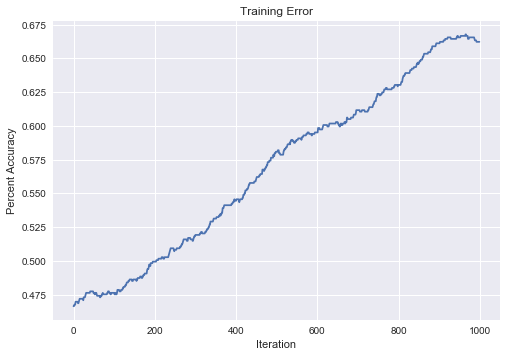

In [146]:
# print(np.array(p))
plt.style.use('seaborn')
plt.plot(p)
plt.title('Training Error')
plt.xlabel('Iteration')
plt.ylabel('Percent Accuracy')
plt.show()